In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [3]:
import yfinance as yf
from yahoofinancials import YahooFinancials
from datetime import date

# get new data from yahoo finance
def get_new_data(ticker, start_date, end_date=date.today()):
    data = yf.download(ticker, start=start_date, end=end_date, progress=False)
    return data

def get_prediction(model, X, scaler):
    # make predictions
    predictions = model.predict(X)
    # inverse transform predictions
    inv_predictions = inverse_transform(predictions, scaler)
    return inv_predictions


def inverse_transform(X, scaler, features=15):
    # Get something which has as many features as dataset
    extended = np.zeros((len(X), features))
    # Put the predictions there
    extended[:, 0:] = X
    # Inverse transform it and select the 3rd column.
    return scaler.inverse_transform(extended)[:, 0]

# convert an array of values into a dataset matrix


def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 1:]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)


In [4]:
# Load Data
df = pd.read_csv("../data/complete-merged-df.csv",
                 index_col=0, parse_dates=True)
# df.head()
future_df = get_new_data('BTC-USD', '2020-12-31')

In [5]:
# load models
from keras.models import load_model

lstm_model = load_model('./saved_models/model3-5.756.h5')
# lstm_model.summary()

In [6]:
# LSTM model prediction
from sklearn.preprocessing import MinMaxScaler

# CONSTS
dataset = df.values  # get raw values from dataframe
TIMESTEPS = 30  # n days in the future to predcict
TRAIN_SIZE = int(len(dataset) * 0.8)  # 80% training set
TEST_SIZE = len(dataset) - TRAIN_SIZE  # 20% test set
FEATURES = 14  # number of features

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# split into train and test sets
train, test = dataset[:TRAIN_SIZE, :], dataset[TRAIN_SIZE:len(dataset), :]

# reshape into X=t and Y=t+1
trainX, trainY = create_dataset(train, TIMESTEPS)
testX, testY = create_dataset(test, TIMESTEPS)

# reshape input to be  [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], TIMESTEPS, FEATURES))
testX = np.reshape(testX, (testX.shape[0], TIMESTEPS, FEATURES))


# Generate list of sequence of days for predictions
datelist_future = pd.date_range(df.index[-1], periods=TIMESTEPS, freq='1d').tolist()
# make a prediction on based on the past 30 days
saved_yhat = get_prediction(lstm_model, testX[-TIMESTEPS:], scaler)


In [7]:
# load saved arima model
from statsmodels.tsa.arima.model import ARIMAResults
import statsmodels.api as sm

ar_model = ARIMAResults.load('./saved_models/arima_model.pkl')
# ar_model.summary()


In [8]:
# get arima predictions
from dateutil.relativedelta import relativedelta
from sklearn.model_selection import train_test_split

top_predictors = ['close', 'open', 'high', 'low', 'n-transactions', 'cost-per-transaction',
                  'Gold price', 'output-volume',  'USD-CNY Price', 'SVI', 'Wikiviews']
top_predictors = df[top_predictors]
_, test = train_test_split(top_predictors, test_size=0.2, shuffle=False)

# create a list of dates to predict
exog_last = sm.add_constant(top_predictors.drop(['close'], axis=1))
start_index = exog_last.index.max().date()
end_index10 = start_index + relativedelta(days=10)
end_index30 = start_index + relativedelta(days=30)

# predict using the fitted model
yhat10 = ar_model.predict(start=start_index, end=end_index10, exog=exog_last[-376:])
yhat30 = ar_model.predict(start=start_index, end=end_index30, exog=exog_last[-396:])

In [9]:
predictions_future = pd.DataFrame(saved_yhat, columns=['lstm_pred']).set_index(pd.Series(datelist_future))
predictions_future['actual'] = future_df.loc[min(predictions_future.index):max(predictions_future.index)].Close
predictions_future['arima_pred30'] = yhat30

<AxesSubplot:>

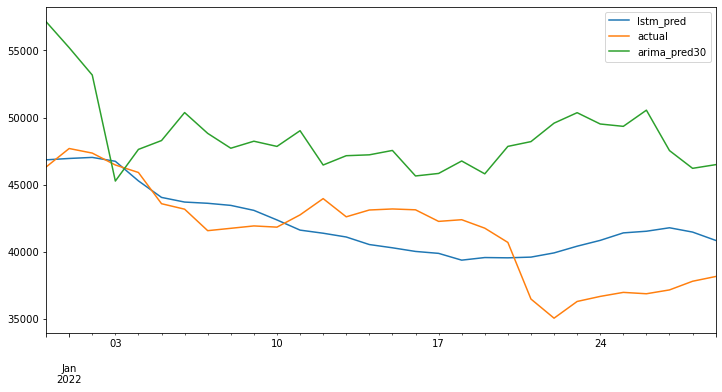

In [10]:
predictions_future.plot(figsize=(12, 6))

In [11]:
from sklearn.metrics import mean_squared_error

lstm_rmse = round(np.sqrt(mean_squared_error(predictions_future['lstm_pred'], predictions_future['actual'])),3)
arima_rmse = round(np.sqrt(mean_squared_error(predictions_future['arima_pred30'], predictions_future['actual'])),3)

Text(0.5, 1.0, 'RMSE of LSTM and ARIMA model')

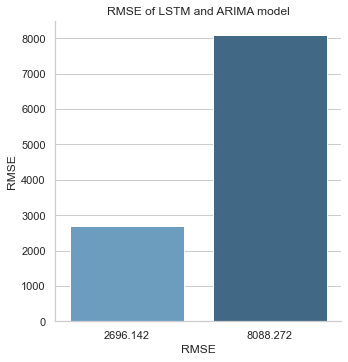

In [12]:
# plot bar chart of rmses
import seaborn as sns
sns.set(style="whitegrid")

rmses = pd.DataFrame([lstm_rmse, arima_rmse], index=['lstm', 'arima'], columns=['RMSE'])

# make the bar width smaller and reduce space between bars
sns.catplot(x='RMSE', y='RMSE', data=rmses, kind='bar', palette='Blues_d')
plt.title('RMSE of LSTM and ARIMA model')

In [13]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0, 1]   # corr
    mins = np.amin(np.hstack([forecast[:, None],
                              actual[:, None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:, None],
                              actual[:, None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax

    return({'mape': str(round(mape*100, 3))+"%", 'mae': mae, 'rmse': rmse})
    # return({'mape': str(round(mape*100, 3))+"%", 'me': me, 'mae': mae,
    #         'mpe': mpe, 'rmse': rmse,
    #         'corr': corr, 'minmax': minmax})


In [39]:
# arima test model
first_predict, last_predict = test.iloc[0].name, test.iloc[-1].name
exog1 = (sm.add_constant(test).loc[first_predict:])
exog1 = exog1.drop(['close'], axis=1)
arima_test = ar_model.forecast(steps=len(test), exog=exog1)

lstm_test = get_prediction(lstm_model, testX, scaler)

# lstm test accuracy
lstm_test = forecast_accuracy(lstm_test, testY)
arima_test = forecast_accuracy(arima_test, test['close'].values)

lstm = forecast_accuracy(predictions_future['lstm_pred'], predictions_future['actual'])
arima = forecast_accuracy(predictions_future['arima_pred30'], predictions_future['actual'])

In [44]:
metrics_test = pd.DataFrame(data={'model': ['LSTM', 'ARIMA'],
                          'RMSE': [lstm['rmse'], arima['rmse']],
                          'MAE': [lstm['mae'], arima['mae']],
                          'RMSE Validation': [lstm_test['rmse'], arima_test['rmse']],
                          'MAE Validation': [lstm_test['mae'], arima_test['mae']]
                          }
                    )
metrics_test['RMSE'] = metrics_test['RMSE'].astype(float)
metrics_test['MAE'] = metrics_test['MAE'].astype(float)

metrics_test = pd.melt(metrics_test, id_vars="model")
metrics_test.columns = ['model', 'Metrics', 'value']

In [45]:
metrics_test

,model,Metrics,value
0,LSTM,RMSE,2696.141980
1,ARIMA,RMSE,8088.271862
2,LSTM,MAE,2263.257840
3,ARIMA,MAE,7153.430449
4,LSTM,RMSE Validation,40727.112805
5,ARIMA,RMSE Validation,1255.572071
6,LSTM,MAE Validation,40140.913567
7,ARIMA,MAE Validation,1021.352455


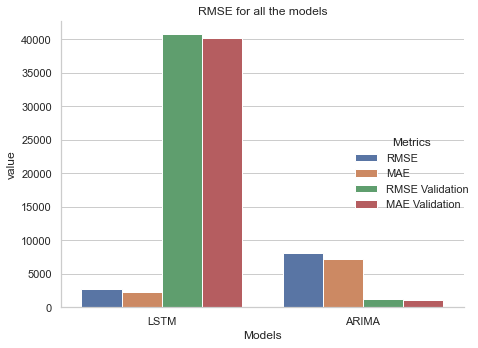

In [46]:
sns.catplot(x='model', y='value', hue='Metrics', data=metrics_test, kind='bar')
plt.xlabel("Models")
plt.title('RMSE for all the models')
plt.tight_layout()